In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import os


In [181]:
# Configuration et Hyperparamètres 
# Inspiré par les annexes C et D de l'article

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparamètres du modèle
IMG_SIZE = 28 * 28  # D (images MNIST)
LATENT_DIM = 2      # d (espace latent plan)
HIDDEN_ENC_1 = 64   # dimension des couches du NN (d'après annexe C Arvanitidis et al.)
HIDDEN_ENC_2 = 32
HIDDEN_DEC_1 = 32
HIDDEN_DEC_2 = 64

# Hyperparamètres de l'entraînement
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
L2_REG = 1e-5
EPOCHS_STAGE_1 = 20 # Entraîner l'encodeur et la moyenne
EPOCHS_STAGE_2 = 10 # Entraîner la variance RBF

# Hyperparamètres de la variance RBF
N_CENTERS = 64     # K, nombre de centres RBF 
A_BANDWIDTH = 1   # Paramètre 'a' pour l'Eq. 12 
RBF_ZETA_INIT = 1e-6 # Petite constante zeta pour éviter la division par zéro

# Choix des digits à encoder
digits_to_use = [1,8,9]

# Chargement des données (MNIST)

print("Chargement des données MNIST...")
transform = transforms.Compose([
    transforms.ToTensor(), # Les pixels sont mis à l'échelle [0, 1] 
])

# Charger le dataset complet
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Fonction pour filtrer les indices pour les chiffres souhaités (digits_to_use)
def get_digit_indices(dataset, digits):
    indices = []
    for i in range(len(dataset)):
        if dataset.targets[i] in digits:
            indices.append(i)
    return indices

# Obtenir les indices souhaités
train_indices = get_digit_indices(train_dataset, digits_to_use)
test_indices = get_digit_indices(test_dataset, digits_to_use)

# Créer des Subsets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Créer les DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Données chargées: {len(train_subset)} images d'entraînement, {len(test_subset)} images de test.")
print(f"Digits chargés : {digits_to_use}")


# Définition des Modules du VAE

class Encoder(nn.Module):
    """
    Encodeur q_phi(z|x).
    Architecture basée sur l'Annexe D.
    La première couche est partagée par mu_phi et sigma_phi.
    """
    def __init__(self):
        super(Encoder, self).__init__()
        # Couche partagée [cite: 606]
        self.shared_layer_1 = nn.Linear(IMG_SIZE, HIDDEN_ENC_1)

        # Branche pour mu_phi
        self.mu_branch = nn.Sequential(
            nn.Tanh(), #
            nn.Linear(HIDDEN_ENC_1, HIDDEN_ENC_2),
            nn.Tanh(), #
            nn.Linear(HIDDEN_ENC_2, LATENT_DIM) # Sortie linéaire pour mu
        )

        # Branche pour logvar_phi (log(sigma^2))
        self.logvar_branch = nn.Sequential(
            nn.Tanh(), #
            nn.Linear(HIDDEN_ENC_1, HIDDEN_ENC_2),
            nn.Tanh(), #
            nn.Linear(HIDDEN_ENC_2, LATENT_DIM)
            # L'article utilise softplus pour sigma, mais
            # l'entraînement de logvar est plus stable numériquement.
        )

    def forward(self, x):
        x_flat = x.view(-1, IMG_SIZE)
        shared_output = self.shared_layer_1(x_flat)
        mu = self.mu_branch(shared_output)
        logvar = self.logvar_branch(shared_output)
        return mu, logvar

class DecoderMean(nn.Module):
    """
    Décodeur pour la moyenne mu_theta(z).
    Architecture basée sur l'Annexe D.
    """
    def __init__(self):
        super(DecoderMean, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DEC_1),
            nn.Tanh(), #
            nn.Linear(HIDDEN_DEC_1, HIDDEN_DEC_2),
            nn.Tanh(), #
            nn.Linear(HIDDEN_DEC_2, IMG_SIZE),
            nn.Sigmoid() # Sigmoid pour des pixels entre [0, 1]
        )

    def forward(self, z):
        return self.net(z)

class DecoderVarianceRBF(nn.Module):
    """
    Décodeur pour la variance, modélisé via la précision beta_psi(z)
    en utilisant un réseau RBF (Section 4.1)[cite: 184].
    beta(z) = W * v(z) + zeta [cite: 186]
    """
    def __init__(self, n_centers=N_CENTERS, d_latent=LATENT_DIM, d_output=IMG_SIZE):
        super(DecoderVarianceRBF, self).__init__()
        self.D = d_output
        self.K = n_centers
        self.d = d_latent

        # Paramètres du RBF: W et zeta
        self.W = nn.Parameter(torch.rand(self.D, self.K) * 0.1)
        # zeta est un vecteur de constantes positives
        self.zeta = nn.Parameter(torch.ones(self.D) * RBF_ZETA_INIT)

        # Centres (c_k) et largeurs de bande (lambda_k)
        # Ce ne sont PAS des paramètres entraînables.
        # Ils sont fixés après l'étape 1.
        self.register_buffer('centers', torch.randn(self.K, self.d))
        self.register_buffer('lambdas', torch.ones(self.K))

    def set_centers_and_bandwidths(self, centers, lambdas):
        """Met à jour les centres et largeurs de bande non-entraînables."""
        self.centers.data.copy_(torch.from_numpy(centers))
        self.lambdas.data.copy_(lambdas)

    def forward(self, z):
        # z est (B, d)
        # centers est (K, d)
        # lambdas est (K)

        # Calculer les distances au carré ||z - c_k||^2
        # (B, 1, d) - (1, K, d) -> (B, K, d)
        z_expanded = z.unsqueeze(1)
        centers_expanded = self.centers.unsqueeze(0)

        # dist_sq: (B, K)
        dist_sq = torch.sum((z_expanded - centers_expanded)**2, dim=2)

        # Calculer les activations RBF v_k(z) = exp(-lambda_k * ||z - c_k||^2) [cite: 186]
        # (B, K) * (1, K) -> (B, K)
        v_z = torch.exp(-self.lambdas.unsqueeze(0) * dist_sq) # (B, K)

        # Calculer la précision beta(z) = W * v(z) + zeta [cite: 186]
        # v_z (B, K), self.W (D, K)
        # (B, K) @ (K, D) -> (B, D)
        beta = F.linear(v_z, self.W, self.zeta)

        # beta doit être > 0. On le clamp à zeta car W >= 0.
        # (La contrainte de positivité sur W est gérée dans la boucle d'entraînement)
        # On ajoute un epsilon pour la stabilité numérique de log(1/beta)
        beta = F.softplus(beta) + RBF_ZETA_INIT

        return beta # (B, D)

    def clamp_weights(self):
        """Applique la contrainte de positivité sur W """
        self.W.data.clamp_(min=0.0)
        self.zeta.data.clamp_(min=RBF_ZETA_INIT)


class VAE(nn.Module):
    """Modèle VAE complet combinant les modules."""
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder().to(DEVICE)
        self.decoder_mean = DecoderMean().to(DEVICE)
        self.decoder_variance_rbf = DecoderVarianceRBF().to(DEVICE)

    def reparameterize(self, mu, logvar):
        """Reparametrization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu_enc, logvar_enc = self.encoder(x)
        z = self.reparameterize(mu_enc, logvar_enc)
        mu_dec = self.decoder_mean(z)
        return mu_dec, z, mu_enc, logvar_enc

    def get_precision_and_variance(self, z):
        """Calcule la précision et la variance à partir du RBF."""
        beta_dec = self.decoder_variance_rbf(z)
        # Assurer que la variance ne devienne pas infinie ou nulle
        beta_dec = torch.clamp(beta_dec, min=1e-6, max=1e6)
        sigma2_dec = 1.0 / beta_dec
        return beta_dec, sigma2_dec


  # Fonction de Perte (ELBO)

def vae_loss_function(x, mu_dec, beta_dec, mu_enc, logvar_enc):
    """
    Calcule la perte VAE (ELBO négatif).
    La log-vraisemblance p(x|z) est N(x | mu_dec, diag(1/beta_dec)).
    """
    x_flat = x.view(-1, IMG_SIZE)

    # 1. Perte de Reconstruction (Log-vraisemblance)
    # log p(x|z) = sum_D { -0.5*log(2pi) - 0.5*log(sigma^2) - 0.5*((x-mu)^2 / sigma^2) }
    # log p(x|z) = sum_D { C + 0.5*log(beta) - 0.5*(x-mu)^2 * beta }
    # On veut maximiser cela, ou minimiser le négatif :

    log_beta = torch.log(beta_dec)
    recon_error = (x_flat - mu_dec)**2 * beta_dec

    # NLL = -log p(x|z)
    # On ignore la constante log(2pi)
    neg_log_likelihood = 0.5 * (recon_error - log_beta)
    recon_loss = torch.sum(neg_log_likelihood, dim=1).mean()

    # 2. Perte KL (Divergence KL) [cite: 74]
    # KL(q(z|x) || p(z)) où p(z) = N(0, I) [cite: 65]
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + logvar_enc - mu_enc.pow(2) - logvar_enc.exp(), dim=1).mean()

    return recon_loss + kld_loss


# Boucle d'entraînement 

model = VAE()

# Entraîner Encodeur et Décodeur de Moyenne 

print("\n--- ÉTAPE 1 : Entraînement Encodeur & Décodeur Moyenne ---")
# Optimiseur pour l'étape 1: ne concerne que l'encodeur et decoder_mean
params_stage_1 = list(model.encoder.parameters()) + list(model.decoder_mean.parameters())
optimizer_stage_1 = optim.Adam(params_stage_1, lr=LEARNING_RATE, weight_decay=L2_REG)

# Variance fixe pour l'étape 1
beta_fixed = torch.ones(BATCH_SIZE, IMG_SIZE).to(DEVICE)

model.train()
for epoch in range(EPOCHS_STAGE_1):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Étape 1 Epoch {epoch+1}")):
        data = data.to(DEVICE)
        optimizer_stage_1.zero_grad()

        mu_dec, z, mu_enc, logvar_enc = model(data)

        # Redimensionner la variance fixe si le dernier batch est plus petit
        current_batch_size = data.size(0)
        if current_batch_size != beta_fixed.size(0):
            beta_fixed_batch = torch.ones(current_batch_size, IMG_SIZE).to(DEVICE)
        else:
            beta_fixed_batch = beta_fixed

        loss = vae_loss_function(data, mu_dec, beta_fixed_batch, mu_enc, logvar_enc)

        loss.backward()
        optimizer_stage_1.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Perte (Étape 1): {epoch_loss / len(train_loader):.4f}")


# Sauvegarder le modèle
save_name = "VAE_MNIST_189.pth"

save_dir = os.path.join(os.getcwd(), "models")
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, save_name)

torch.save(model.state_dict(), save_path)

print(f"Modèle sauvegardé dans {save_path}")



Chargement des données MNIST...
Données chargées: 18542 images d'entraînement, 3118 images de test.
Digits chargés : [1, 8, 9]

--- ÉTAPE 1 : Entraînement Encodeur & Décodeur Moyenne ---


Étape 1 Epoch 1: 100%|██████████| 145/145 [00:02<00:00, 54.62it/s]


Epoch 1 Perte (Étape 1): 33.7347


Étape 1 Epoch 2: 100%|██████████| 145/145 [00:02<00:00, 59.25it/s]


Epoch 2 Perte (Étape 1): 21.4049


Étape 1 Epoch 3: 100%|██████████| 145/145 [00:02<00:00, 58.68it/s]


Epoch 3 Perte (Étape 1): 19.6733


Étape 1 Epoch 4: 100%|██████████| 145/145 [00:02<00:00, 59.28it/s]


Epoch 4 Perte (Étape 1): 19.2072


Étape 1 Epoch 5: 100%|██████████| 145/145 [00:02<00:00, 57.62it/s]


Epoch 5 Perte (Étape 1): 19.0370


Étape 1 Epoch 6: 100%|██████████| 145/145 [00:02<00:00, 59.25it/s]


Epoch 6 Perte (Étape 1): 18.9151


Étape 1 Epoch 7: 100%|██████████| 145/145 [00:02<00:00, 56.46it/s]


Epoch 7 Perte (Étape 1): 18.7632


Étape 1 Epoch 8: 100%|██████████| 145/145 [00:02<00:00, 56.08it/s]


Epoch 8 Perte (Étape 1): 18.6651


Étape 1 Epoch 9: 100%|██████████| 145/145 [00:02<00:00, 56.66it/s]


Epoch 9 Perte (Étape 1): 18.5590


Étape 1 Epoch 10: 100%|██████████| 145/145 [00:02<00:00, 56.10it/s]


Epoch 10 Perte (Étape 1): 18.4398


Étape 1 Epoch 11: 100%|██████████| 145/145 [00:02<00:00, 57.05it/s]


Epoch 11 Perte (Étape 1): 18.3144


Étape 1 Epoch 12: 100%|██████████| 145/145 [00:02<00:00, 56.87it/s]


Epoch 12 Perte (Étape 1): 18.1125


Étape 1 Epoch 13: 100%|██████████| 145/145 [00:02<00:00, 58.55it/s]


Epoch 13 Perte (Étape 1): 17.9430


Étape 1 Epoch 14: 100%|██████████| 145/145 [00:02<00:00, 55.23it/s]


Epoch 14 Perte (Étape 1): 17.7885


Étape 1 Epoch 15: 100%|██████████| 145/145 [00:02<00:00, 56.39it/s]


Epoch 15 Perte (Étape 1): 17.6571


Étape 1 Epoch 16: 100%|██████████| 145/145 [00:02<00:00, 56.97it/s]


Epoch 16 Perte (Étape 1): 17.5206


Étape 1 Epoch 17: 100%|██████████| 145/145 [00:02<00:00, 56.50it/s]


Epoch 17 Perte (Étape 1): 17.4037


Étape 1 Epoch 18: 100%|██████████| 145/145 [00:02<00:00, 56.82it/s]


Epoch 18 Perte (Étape 1): 17.2804


Étape 1 Epoch 19: 100%|██████████| 145/145 [00:02<00:00, 57.25it/s]


Epoch 19 Perte (Étape 1): 17.1642


Étape 1 Epoch 20: 100%|██████████| 145/145 [00:02<00:00, 57.75it/s]

Epoch 20 Perte (Étape 1): 17.0788
Modèle sauvegardé dans c:\Users\alex\kDrive\Cours\M2 MVA\Geometric Data Analysis\LSO_implementation\models\VAE_MNIST_189.pth


Encodage des données de test: 100%|██████████| 25/25 [00:00<00:00, 78.98it/s]


Graphique généré à partir de 3118 points.


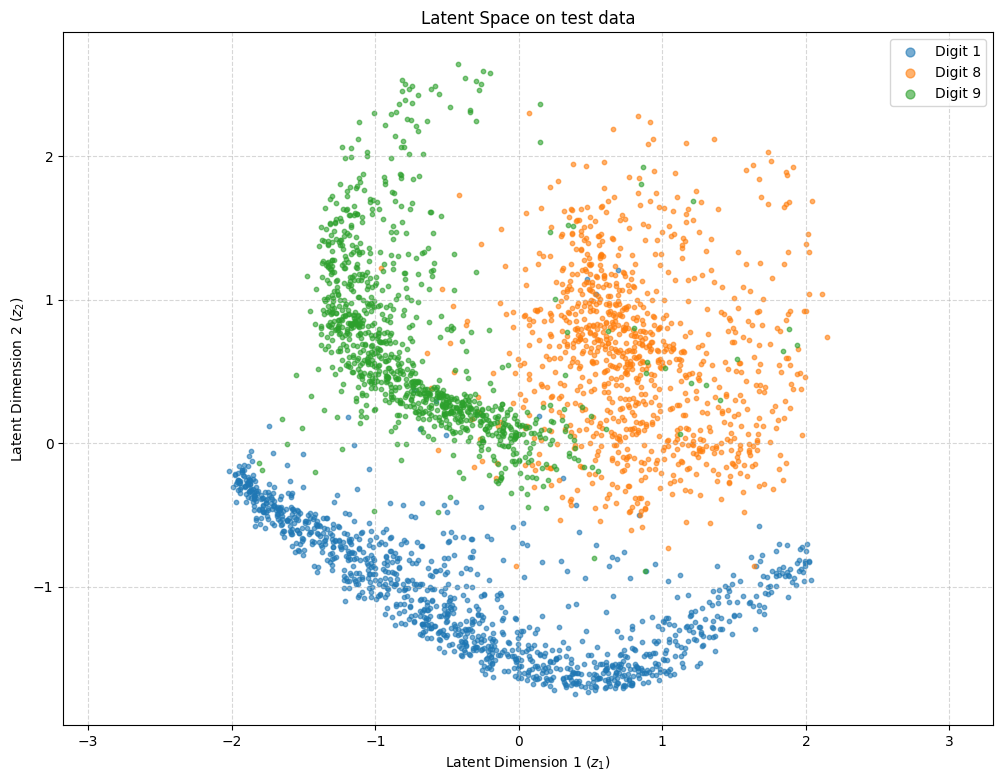

In [183]:
model = VAE()  

model_name = "VAE_MNIST_189_rapport.pth"
save_dir = os.path.join(os.getcwd(), "models")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

# Listes pour collecter les points (mu) et les labels
latents_list = []
labels_list = []

# Itérer sur les données de test (sans calcul de gradient)
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc="Encodage des données de test"):
        data = data.to(DEVICE)

        # Passer les images dans l'encodeur pour obtenir mu et logvar
        # Nous n'utilisons que mu pour la position du point
        mu, logvar = model.encoder(data)

        # Stocker les résultats (en les déplaçant vers le CPU)
        latents_list.append(mu.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convertir les listes en un seul array NumPy
all_latents = np.concatenate(latents_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)

print(f"Graphique généré à partir de {all_latents.shape[0]} points.")

# Créer le graphique
plt.figure(figsize=(12, 9))

# Séparer les données par label pour la couleur et la légende

for digit in digits_to_use:
  latents = all_latents[all_labels == digit]
  plt.scatter(
    latents[:, 0],
    latents[:, 1],
    label='Digit {}'.format(digit),
    alpha=0.6,  # Transparence
    s=10        # Taille des points
)

# Ajouter les titres, labels et légende
plt.title("Latent Space on test data")
plt.xlabel("Latent Dimension 1 ($z_1$)")
plt.ylabel("Latent Dimension 2 ($z_2$)")
plt.legend(markerscale=2) # Agrandir les points de la légende
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal') # Assure que les axes ont la même échelle

# Afficher le graphique
plt.show()

Vecteur latent : tensor([[-0.9226,  0.3721]], device='cuda:0')


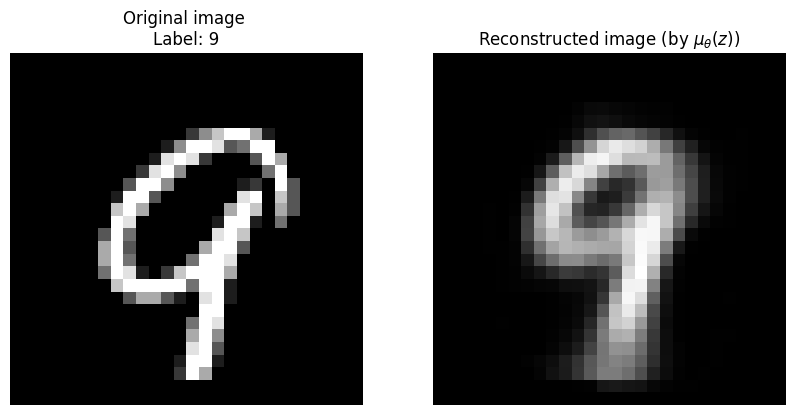

In [184]:
# Vérifier la capacité de reconstruction du modèle
# Affichage d'une image, et de l'image reconstruite

# Mettre le modèle en mode évaluation 
model.eval()

# Obtenir une image d'entraînement 
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Sélectionner la première image du batch
img = images[0].to(DEVICE)

label = labels[0]

# Passer l'image dans le VAE
with torch.no_grad():
    mu, logvar = model.encoder(img)
    print("Vecteur latent : {}".format(mu))
    reconstructed_img_mu = model.decoder_mean(mu) # Sortie de forme (1, 784)

# Préparer les images pour l'affichage 
original_img_np = img.cpu().numpy().squeeze()
reconstructed_img_np = reconstructed_img_mu.view(28, 28).cpu().numpy()

# Afficher les images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Afficher l'image originale
ax1.imshow(original_img_np, cmap='gray')
ax1.set_title(f"Original image \nLabel: {label.item()}")
ax1.axis('off')

# Afficher l'image reconstruite
ax2.imshow(reconstructed_img_np, cmap='gray')
ax2.set_title(r"Reconstructed image (by $\mu_{\theta}(z)$)")
ax2.axis('off')

plt.show()

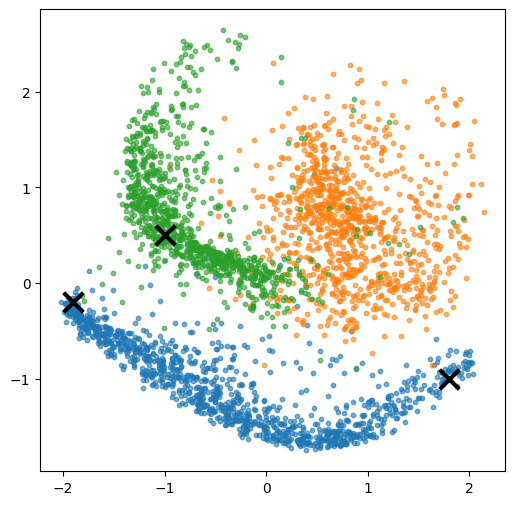

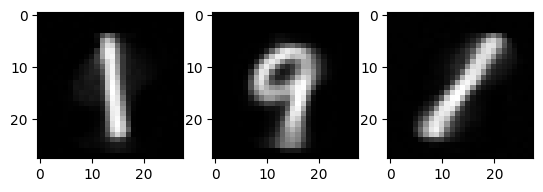

Distance Euclidienne entre z1 et z2: 1.1402
Distance Euclidienne entre z1 et z3: 3.7855
Distance Euclidienne entre z2 et z3: 3.1765


In [186]:
z1_coord = [-1.9,-0.2]
z2_coord = [-1,0.5]
z3_coord = [1.8,-1.0]

z1 = torch.tensor(z1_coord, dtype=torch.float32).to(DEVICE)
z2 = torch.tensor(z2_coord, dtype=torch.float32).to(DEVICE)
z3 = torch.tensor(z3_coord, dtype=torch.float32).to(DEVICE)

dist12 = torch.norm(z1 - z2)
dist13 = torch.norm(z1 - z3)
dist23 = torch.norm(z2 - z3)


plt.figure(figsize=(6, 6))

for digit in digits_to_use:
  latents = all_latents[all_labels == digit]
  plt.scatter(
    latents[:, 0],
    latents[:, 1],
    label='Chiffre {}'.format(digit),
    alpha=0.6,  # Transparence
    s=10        # Taille des points
)

for z in [z1_coord, z2_coord, z3_coord]:
  plt.scatter(
      z[0], z[1],
      marker='x',
      s=200,
      linewidths=3,
      color='black',
      zorder=10,
      label='latent'
  )

plt.show()
for i,z in enumerate([z1, z2, z3]):
  with torch.no_grad():
    reconstructed_img_mu = model.decoder_mean(z) # Sortie de forme (1, 784)
    reconstructed_img_np = reconstructed_img_mu.view(28, 28).cpu().numpy()

  plt.subplot(1,3,i+1)
  plt.imshow(reconstructed_img_np, cmap='gray')
plt.show()

print(f"Distance Euclidienne entre z1 et z2: {dist12.item():.4f}")
print(f"Distance Euclidienne entre z1 et z3: {dist13.item():.4f}")
print(f"Distance Euclidienne entre z2 et z3: {dist23.item():.4f}")


--- Configuration du Réseau RBF ---
Calcul des représentations latentes...
Application de k-means (K=64)...
Calcul des largeurs de bande (lambda_k)...
(64, 2) torch.Size([64])
Centres RBF et largeurs de bande configurés.

--- ÉTAPE 2 : Entraînement Décodeur Variance (RBF) ---


Étape 2 Epoch 1: 100%|██████████| 145/145 [00:02<00:00, 64.45it/s]


Epoch 1 Perte (Étape 2): -323.8911


Étape 2 Epoch 2: 100%|██████████| 145/145 [00:02<00:00, 64.49it/s]


Epoch 2 Perte (Étape 2): -358.9868


Étape 2 Epoch 3: 100%|██████████| 145/145 [00:02<00:00, 65.20it/s]


Epoch 3 Perte (Étape 2): -386.9557


Étape 2 Epoch 4: 100%|██████████| 145/145 [00:02<00:00, 63.99it/s]


Epoch 4 Perte (Étape 2): -414.5297


Étape 2 Epoch 5: 100%|██████████| 145/145 [00:02<00:00, 65.62it/s]


Epoch 5 Perte (Étape 2): -438.3422


Étape 2 Epoch 6: 100%|██████████| 145/145 [00:02<00:00, 64.97it/s]


Epoch 6 Perte (Étape 2): -459.3865


Étape 2 Epoch 7: 100%|██████████| 145/145 [00:02<00:00, 65.43it/s]


Epoch 7 Perte (Étape 2): -479.4368


Étape 2 Epoch 8: 100%|██████████| 145/145 [00:02<00:00, 64.97it/s]


Epoch 8 Perte (Étape 2): -499.4175


Étape 2 Epoch 9: 100%|██████████| 145/145 [00:02<00:00, 59.75it/s]


Epoch 9 Perte (Étape 2): -516.5580


Étape 2 Epoch 10: 100%|██████████| 145/145 [00:02<00:00, 62.34it/s]


Epoch 10 Perte (Étape 2): -531.7929

--- Entraînement Terminé ---
Points de test chargés.
Calcul de la variance sur une grille de 150x150 points...


Calcul variance: 100%|██████████| 22/22 [00:00<00:00, 233.63it/s]

Calcul terminé.



C:\Users\alex\AppData\Local\Temp\ipykernel_32664\2586643909.py:203: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=10)


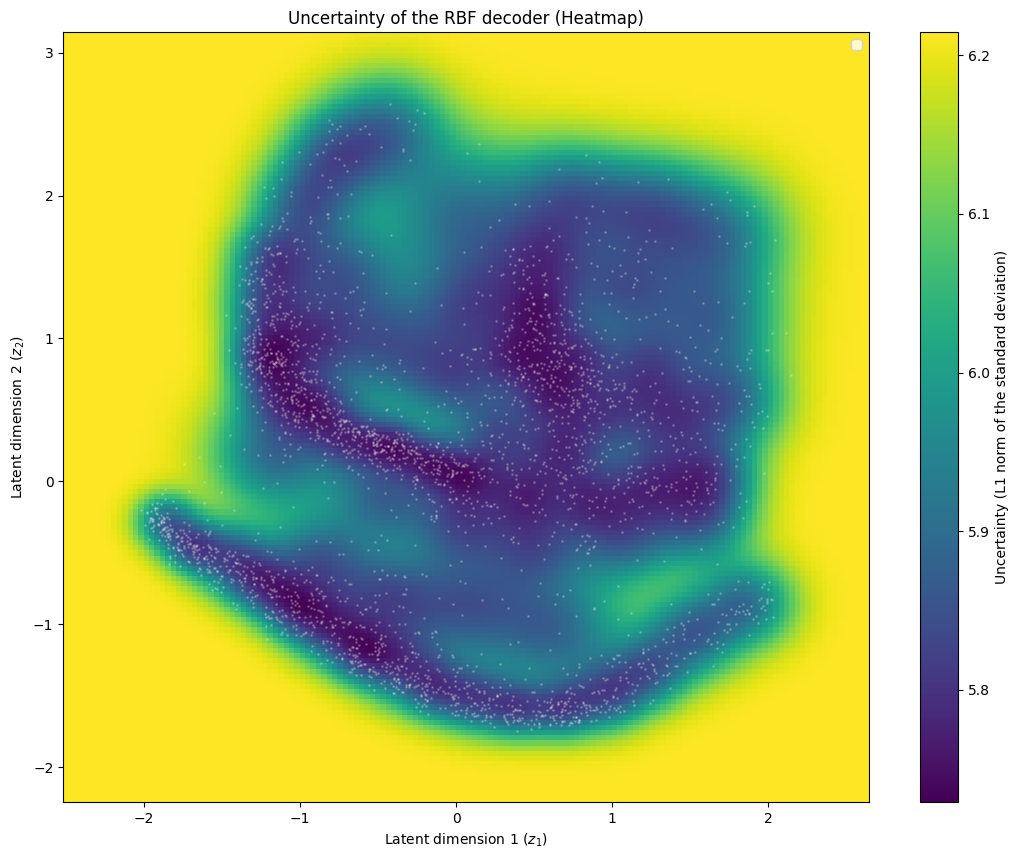

In [ ]:
print("\n--- Configuration du Réseau RBF ---")
model.encoder.eval() # Geler l'encodeur
A_BANDWIDTH = 1.3   # paramètre a
#%matplotlib tk
#%matplotlib inline

# Obtenir toutes les représentations latentes
print("Calcul des représentations latentes...")
all_latents = []
with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(DEVICE)
        mu_enc, _ = model.encoder(data)
        all_latents.append(mu_enc.cpu())
all_latents = torch.cat(all_latents, dim=0).numpy()

# Appliquer k-means pour trouver les centres c_k
print(f"Application de k-means (K={N_CENTERS})...")
kmeans = KMeans(n_clusters=N_CENTERS, random_state=42, n_init=10)
kmeans.fit(all_latents)
centers_ck = kmeans.cluster_centers_ # (K, d)
labels = kmeans.labels_

# Calculer les largeurs de bande lambda_k 
print("Calcul des largeurs de bande (lambda_k)...")
lambdas_lk, ck = [], []
all_latents_torch = torch.from_numpy(all_latents)
centers_ck_torch = torch.from_numpy(centers_ck)

for k in range(N_CENTERS):
    cluster_points = all_latents_torch[labels == k]
    if len(cluster_points) == 0:
        # Gérer le cas (improbable) d'un cluster vide
        avg_dist = torch.tensor(1.0)
    else:
        dists = torch.norm(cluster_points - centers_ck_torch[k], p=2, dim=1)
        avg_dist = torch.mean(dists) # 1/|C_k| * sum(||z_j - c_k||)
        
    if avg_dist < 1e-6: avg_dist = 1e-6

    bandwidth_sq = (A_BANDWIDTH * avg_dist)**2
    lambda_k = 1.0 / (2.0 * bandwidth_sq)
    lambdas_lk.append(lambda_k)
    ck.append(len(cluster_points))

lambdas_lk_tensor = torch.tensor(lambdas_lk, dtype=torch.float32).to(DEVICE)

# Mettre à jour le module RBF
print(centers_ck.shape, lambdas_lk_tensor.shape)
model.decoder_variance_rbf.set_centers_and_bandwidths(centers_ck, lambdas_lk_tensor)
print("Centres RBF et largeurs de bande configurés.")

# Entraîner le Décodeur de Variance RBF

print("\nEntraînement Décodeur Variance (RBF)")
# Geler l'encodeur et le décodeur de moyenne
model.encoder.eval()
model.decoder_mean.eval()
model.decoder_variance_rbf.train()

# Optimiseur pour l'étape 2: ne concerne que le RBF
# L'article mentionne 'projected gradient descent'
# Nous utilisons Adam avec une projection (clamp) manuelle
optimizer_stage_2 = optim.Adam(model.decoder_variance_rbf.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

for epoch in range(EPOCHS_STAGE_2):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Étape 2 Epoch {epoch+1}")):
        data = data.to(DEVICE)
        optimizer_stage_2.zero_grad()

        # Obtenir z et mu_dec sans gradient
        with torch.no_grad():
            mu_enc, logvar_enc = model.encoder(data)
            z = model.reparameterize(mu_enc, logvar_enc)
            mu_dec = model.decoder_mean(z)

        # Calculer la précision (avec gradient)
        beta_dec, _ = model.get_precision_and_variance(z)

        loss = vae_loss_function(data, mu_dec, beta_dec, mu_enc, logvar_enc)

        loss.backward()
        optimizer_stage_2.step()

        # Appliquer la contrainte de positivité (Projected Gradient)
        model.decoder_variance_rbf.clamp_weights()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Perte (Étape 2): {epoch_loss / len(train_loader):.4f}")

print("\n--- Entraînement Terminé ---")

model.eval()
# Obtenir les points de test (comme avant)
latents_list = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(DEVICE)
        mu, _ = model.encoder(data)
        latents_list.append(mu.cpu().numpy())
all_latents = np.concatenate(latents_list, axis=0)

print("Points de test chargés.")

# Créer la Grille de l'Espace Latent 

# Déterminer les bornes de la grille à partir des données de test, avec une marge
margin = 0.5
x_min, x_max = all_latents[:, 0].min() - margin, all_latents[:, 0].max() + margin
y_min, y_max = all_latents[:, 1].min() - margin, all_latents[:, 1].max() + margin

# Définir la résolution de la grille
grid_resolution = 150
xx = np.linspace(x_min, x_max, grid_resolution)
yy = np.linspace(y_min, y_max, grid_resolution)
grid_x, grid_y = np.meshgrid(xx, yy)

# Aplatir la grille en un batch de points (N, 2)
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32).to(DEVICE)

print(f"Calcul de la variance sur une grille de {grid_resolution}x{grid_resolution} points...")

# Calculer la Variance sur la Grille 

# Liste pour stocker les valeurs de la heatmap
heatmap_values = []

min_sum_sigma = float('inf') #sert pour calculer la métrique modifiée

# Traiter par mini-batchs pour éviter de saturer la mémoire GPU
batch_size = 1024
with torch.no_grad():
    for i in tqdm(range(0, len(grid_points_tensor), batch_size), desc="Calcul variance"):
        batch_z = grid_points_tensor[i:i + batch_size]

        # Obtenir la précision (beta) du décodeur RBF
        beta_dec = model.decoder_variance_rbf(batch_z) # (B, D)

        # Gérer la stabilité numérique
        beta_dec = torch.clamp(beta_dec, min=1e-12)

        # 1. Précision -> Variance (sigma^2)
        sigma2_dec = 1.0 / beta_dec

        # 2. Variance -> Écart-type (sigma)
        sigma_dec = torch.sqrt(sigma2_dec)

        # 3. Somme des écarts-types (comme Fig. 4)
        sum_sigma = torch.sum(sigma_dec, dim=1) # (B,)

        # 4. Log de la somme
        log_sum_sigma = torch.log(sum_sigma)

        heatmap_values.append(log_sum_sigma.cpu().numpy())

        if torch.min(sum_sigma).item() < min_sum_sigma:
            min_sum_sigma = torch.min(sum_sigma).item()

# Concaténer les résultats des batchs
heatmap_values = np.concatenate(heatmap_values)

# Remodeler en une image 2D 
heatmap_image = heatmap_values.reshape(grid_resolution, grid_resolution)

print("Calcul terminé.")

# Afficher la Heatmap et les Points

plt.figure(figsize=(13, 10))

# Afficher la heatmap (la variance)
# 'origin=lower' est crucial pour aligner (0,0) en bas à gauche
# 'extent' mappe les pixels de l'image aux coordonnées de l'espace latent
im = plt.imshow(
    heatmap_image,
    cmap='viridis', # Vous pouvez essayer 'plasma', 'inferno', 'magma'
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    aspect='auto'
)

# Ajouter la barre de couleur
cbar = plt.colorbar(im)
cbar.set_label("Uncertainty (L1 norm of the standard deviation)")

# Superposer les points de test
plt.scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,                     # Très petits points
    c='white',               # Couleur contrastante
    alpha=0.2,               # Transparence
    label=''
)

# Titres et labels
plt.title("Uncertainty of the RBF decoder (Heatmap)")
plt.xlabel("Latent dimension 1 ($z_1$)")
plt.ylabel("Latent dimension 2 ($z_2$)")
plt.legend(markerscale=10) 
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

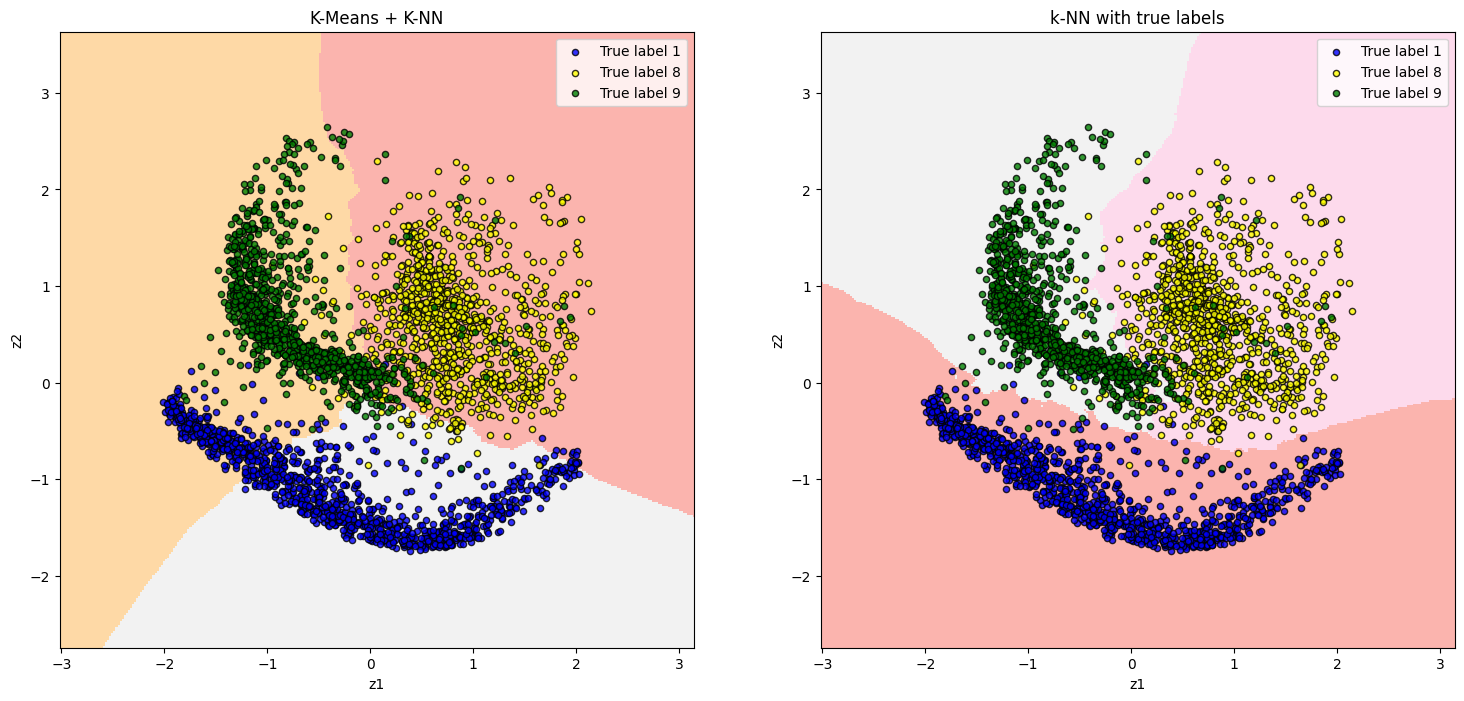

=== Évaluation du clustering K-means ===
Exactitude : 24.79%
Erreur     : 75.21%
F1-score   : 15.79%


In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score

# Entraînement K-Means 
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(all_latents)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Création de la grille 2D 
x_min, x_max = all_latents[:, 0].min() - 1, all_latents[:, 0].max() + 1
y_min, y_max = all_latents[:, 1].min() - 1, all_latents[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h, dtype=np.float64),
                     np.arange(y_min, y_max, h, dtype=np.float64))
grid = np.c_[xx.ravel(), yy.ravel()]

# k-NN sur clusters K-Means 
knn_clusters = KNeighborsClassifier(n_neighbors=7)
knn_clusters.fit(all_latents, cluster_labels)
Z_clusters = knn_clusters.predict(grid).reshape(xx.shape)

# k-NN sur vrais labels 
knn_true = KNeighborsClassifier(n_neighbors=7)
knn_true.fit(all_latents, all_labels)
Z_true = knn_true.predict(grid).reshape(xx.shape)

# Visualisation côte à côte 
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Couleurs et labels
unique_labels = np.unique(all_labels)
colors = ['blue', 'yellow', 'green']

# Visualisation K-Means + K-NN 
axes[0].imshow(
    Z_clusters,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel1,
    aspect='auto',
    origin='lower'
)
for i, digit in enumerate(unique_labels):
    idx = all_labels == digit
    axes[0].scatter(all_latents[idx, 0], all_latents[idx, 1],
                    c=colors[i % len(colors)], label=f'True label {digit}',
                    edgecolor='k', s=20, alpha=0.8)
axes[0].set_xlabel("z1")
axes[0].set_ylabel("z2")
axes[0].set_title("K-Means + K-NN")
axes[0].legend()

#  k-NN sur vrais labels 
axes[1].imshow(
    Z_true,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel1,
    aspect='auto',
    origin='lower'
)
for i, digit in enumerate(unique_labels):
    idx = all_labels == digit
    axes[1].scatter(all_latents[idx, 0], all_latents[idx, 1],
                    c=colors[i % len(colors)], label=f'True label {digit}',
                    edgecolor='k', s=20, alpha=0.8)
axes[1].set_xlabel("z1")
axes[1].set_ylabel("z2")
axes[1].set_title("k-NN with true labels")
axes[1].legend()

plt.show()

# Calcul des performances du clustering K-Means 
n_classes = len(unique_labels)
confusion = np.zeros((n_classes, n_classes), dtype=int)
for c, t in zip(cluster_labels, all_labels):
    if t == 8:
        t = 2
    elif t == 9:
        t = 0
    confusion[c, t] += 1

# Mapping clusters -> classes
mapping = confusion.argmax(axis=1)
pred_mapped = np.array([mapping[c] for c in cluster_labels])

acc = accuracy_score(all_labels, pred_mapped)
error = (1 - acc) * 100
f1 = f1_score(all_labels, pred_mapped, average='macro')

print("=== Évaluation du clustering K-means ===")
print(f"Exactitude : {acc*100:.2f}%")
print(f"Erreur     : {error:.2f}%")
print(f"F1-score   : {f1*100:.2f}%")


Résolution du BVP pour la géodésique... (cela peut être très lent)
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.05e-01       0.00e+00           3              3       
       2          1.95e-01       0.00e+00           6              8       
       3          3.28e-02       0.00e+00          14             13       
       4          3.58e-03       0.00e+00          27              5       
       5          9.20e-04       0.00e+00          32              0       
Solved in 5 iterations, number of nodes 32. 
Maximum relative residual: 9.20e-04 
Maximum boundary residual: 0.00e+00
Résolution terminée en 32.30 secondes.
Message du solveur: The algorithm converged to the desired accuracy.

Distance Géodésique (longueur du chemin) : 1.6197


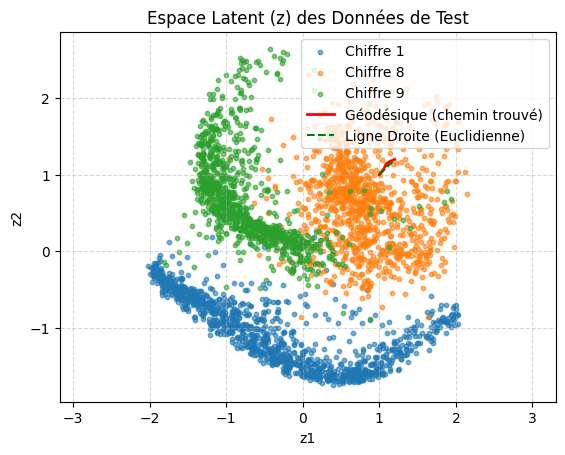

In [193]:
from torch.func import jacrev
from scipy.integrate import solve_bvp
import time


model.eval()

# Fonction get_riemannian_metric 

def get_riemannian_metric(z_point, model):
    """
    Calcule la métrique Riemannienne M_z (Théorème 1).
    Cette fonction DOIT être différentiable.
    """
    model.eval()

    z_point = z_point.to(DEVICE).float()

    # Fonctions internes pour jacrev
    def mean_func_unbatched(z):
        return model.decoder_mean(z)  # Simplified, `nn.Linear` handles (d,) input

    def std_dev_func_unbatched(z):
        beta_dec = model.decoder_variance_rbf(z.unsqueeze(0)) # RBF expects (B, d)
        beta_dec = torch.clamp(beta_dec, min=1e-12)
        sigma_dec = torch.sqrt(1.0 / beta_dec)
        return sigma_dec.squeeze(0)

    # Le calcul des jacobiens (dérivées premières) doit
    # être dans un bloc enable_grad()
    # pour que le jacobien de cette fonction (dérivée seconde) puisse être calculé.
    with torch.enable_grad():
        J_mu = jacrev(mean_func_unbatched)(z_point)
        J_sigma = jacrev(std_dev_func_unbatched)(z_point)

    M_z = (J_mu.T @ J_mu) + 10 * (J_sigma.T @ J_sigma)
    return M_z

# Fonction get_metric_and_gradient

def get_metric_and_gradient(z, model):
    """
    Calcule M_z et son gradient d_z_M_z.
    """
    z = z.to(DEVICE).float()

    # 1. Calculer dM_dz (Hessiens)
    # Nécessite des gradients, donc enable_grad()
    with torch.enable_grad():
        # dM_dz a la forme (d, d, d)
        # dM_dz[k, i, j] = d(M_ij) / d(z_k)
        dM_dz = jacrev(get_riemannian_metric)(z, model)

    # 2. Calculer M_z
    # Pas besoin de gradients pour ce calcul
    with torch.no_grad():
        M_z = get_riemannian_metric(z, model)

    return M_z, dM_dz

# Définition du Système d'EDOs

def geodesic_ode_system(t, y, model, latent_dim):
    """
    Définit le système d'EDOs pour scipy.integrate.solve_bvp.
    Prend TOUS les nœuds (y.shape = (2*d, n_nodes))
    Retourne la dérivée pour TOUS les nœuds (dydt.shape = (2*d, n_nodes))
    """

    n_nodes = y.shape[1]
    # Préparer le tableau de sortie
    dydt = np.zeros_like(y)

    # Boucler sur chaque nœud de temps
    for i in range(n_nodes):
        # Extraire la position et la vélocité pour le nœud i
        z_np = y[:latent_dim, i]
        v_np = y[latent_dim:, i]

        z = torch.tensor(z_np, dtype=torch.float32).to(DEVICE)
        v = torch.tensor(v_np, dtype=torch.float32).to(DEVICE)

        # 1. Obtenir M_z et dM_dz (coûteux)
        M_z, dM_dz = get_metric_and_gradient(z, model)

        # 2. Inverser M_z
        try:
            M_inv = torch.inverse(M_z)
        except torch._C._LinAlgError:
            M_inv = torch.eye(latent_dim, device=DEVICE) # Fallback

        # 3. Calculer l'accélération (Eq. 23)
        d = latent_dim
        v_kron_v = torch.kron(v, v) # (d*d,)

        dM_vec_T = dM_dz.permute(1, 2, 0).reshape(d*d, d).T
        dM_mat = dM_dz.reshape(d, d*d)
        bracket_matrix = (2 * dM_mat) - dM_vec_T
        bracket_vector = bracket_matrix @ v_kron_v
        accel_ddot = -0.5 * (M_inv @ bracket_vector)

        # 4. Remplir le tableau de sortie pour le nœud i
        dydt[:latent_dim, i] = v_np
        dydt[latent_dim:, i] = accel_ddot.detach().cpu().numpy()

    return dydt

# Définition des Conditions aux Limites

def boundary_conditions(y_a, y_b, z_a_np, z_b_np, latent_dim):
    """
    Impose que y_a (début) soit z_a et y_b (fin) soit z_b.
    """
    start_condition = y_a[:latent_dim] - z_a_np
    end_condition = y_b[:latent_dim] - z_b_np
    return np.concatenate([start_condition, end_condition])

# Fonction Principale

def calculate_true_geodesic(z_a, z_b, model, n_nodes=20):
    """
    Calcule la géodésique entre z_a et z_b en résolvant le BVP.
    """
    z_a_np = z_a.cpu().numpy()
    z_b_np = z_b.cpu().numpy()
    latent_dim = z_a.shape[0]

    t_nodes = np.linspace(0.0, 1.0, n_nodes)
    y_guess = np.zeros((2 * latent_dim, n_nodes))

    for i in range(latent_dim):
        y_guess[i, :] = z_a_np[i] + t_nodes * (z_b_np[i] - z_a_np[i])
        y_guess[i + latent_dim, :] = z_b_np[i] - z_a_np[i]

    print("Résolution du BVP pour la géodésique... (cela peut être très lent)")
    start_time = time.time()

    sol = solve_bvp(
        lambda t, y: geodesic_ode_system(t, y, model, latent_dim),
        lambda ya, yb: boundary_conditions(ya, yb, z_a_np, z_b_np, latent_dim),
        t_nodes,
        y_guess,
        verbose=2
    )

    end_time = time.time()
    print(f"Résolution terminée en {end_time - start_time:.2f} secondes.")
    print(f"Message du solveur: {sol.message}")

    if not sol.success:
        print("AVERTISSEMENT: Le solveur n'a pas convergé !")

    return sol.sol

# Fonction pour calculer la longueur

@torch.no_grad()
def get_path_length(path_tensor, model):
    """Calcule la longueur Riemannienne d'un chemin donné."""
    total_distance = 0.0
    for i in range(len(path_tensor) - 1):
        z_i = path_tensor[i]
        z_j = path_tensor[i+1]
        dz = z_j - z_i

        z_mid = (z_i + z_j) / 2.0
        M_z = get_riemannian_metric(z_mid, model)

        dz_row = dz.unsqueeze(0)
        dz_col = dz.unsqueeze(-1)
        length_sq = dz_row @ M_z @ dz_col
        segment_length = torch.sqrt(torch.clamp(length_sq, min=1e-12))
        total_distance += segment_length.item()
    return total_distance


@torch.no_grad()
def get_path_length_modified(path_tensor, model):
    """Calcule la longueur Riemannienne d'un chemin donné. Version améliorée en réajustant la valeur de la variance RBF"""
    total_distance = 0.0
    for i in range(len(path_tensor) - 1):
        z_i = path_tensor[i]
        z_j = path_tensor[i+1]
        dz = z_j - z_i

        z_mid = (z_i + z_j) / 2.0
        M_z = get_riemannian_metric(z_mid, model)

        dz_row = dz.unsqueeze(0)
        dz_col = dz.unsqueeze(-1)
        length_sq = dz_row @ M_z @ dz_col
        segment_length = torch.sqrt(torch.clamp(length_sq, min=1e-12))
        total_distance += segment_length.item()
    return total_distance




# Deux points de test
za = torch.tensor([1.0,1.0], dtype=torch.float32)
zb = torch.tensor([1.2,1.2], dtype=torch.float32)

# 1. Calculer la géodésique
geodesic_solution = calculate_true_geodesic(za, zb, model, n_nodes=3)

# 2. Obtenir les points du chemin pour le plot
plot_t = np.linspace(0.0, 1.0, 50)
path_points_y = geodesic_solution(plot_t) # Forme (2*d, 50)
geodesic_path = path_points_y[:2, :].T    # Forme (50, 2)

# 3. Calculer la distance (longueur du chemin)
path_tensor = torch.tensor(geodesic_path, dtype=torch.float32).to(DEVICE)
distance_geo = get_path_length(path_tensor, model)

print(f"\nDistance Géodésique (longueur du chemin) : {distance_geo:.4f}")


for digit in digits_to_use:
      latents = all_latents[all_labels == digit]
      plt.scatter(
        latents[:, 0],
        latents[:, 1],
        label='Chiffre {}'.format(digit),
        alpha=0.6,  # Transparence
        s=10        # Taille des points
    )

plt.title("Espace Latent (z) des Données de Test")

plt.legend(markerscale=2) # Agrandir les points de la légende
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal') # Assure que les axes ont la même échelle

plt.plot(geodesic_path[:, 0], geodesic_path[:, 1], 'r-', label='Géodésique (chemin trouvé)', linewidth=2)

# Plot du chemin "naïf" (ligne droite)
naive_path = np.vstack([np.linspace(za[0], zb[0], 50), np.linspace(za[1], zb[1], 50)]).T
plt.plot(naive_path[:, 0], naive_path[:, 1], 'g--', label='Ligne Droite (Euclidienne)')

plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


Calcul des géodésiques (Méthode Yang et al. 2018)...


Loss: 10792.59: 100%|██████████| 200/200 [00:00<00:00, 268.46it/s]     


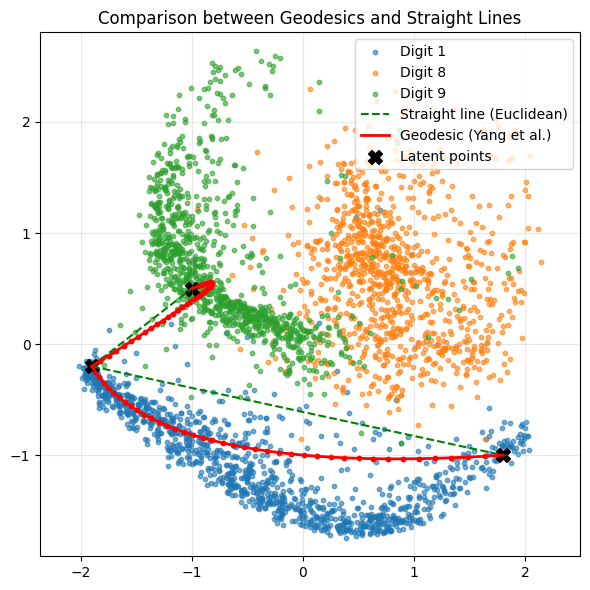

Longueur de la géodésique AB : 30.61
Longueur de la ligne droite AB : 27.65
Longueur de la géodésique AC : 35.07
Longueur de la ligne droite AC : 38.09


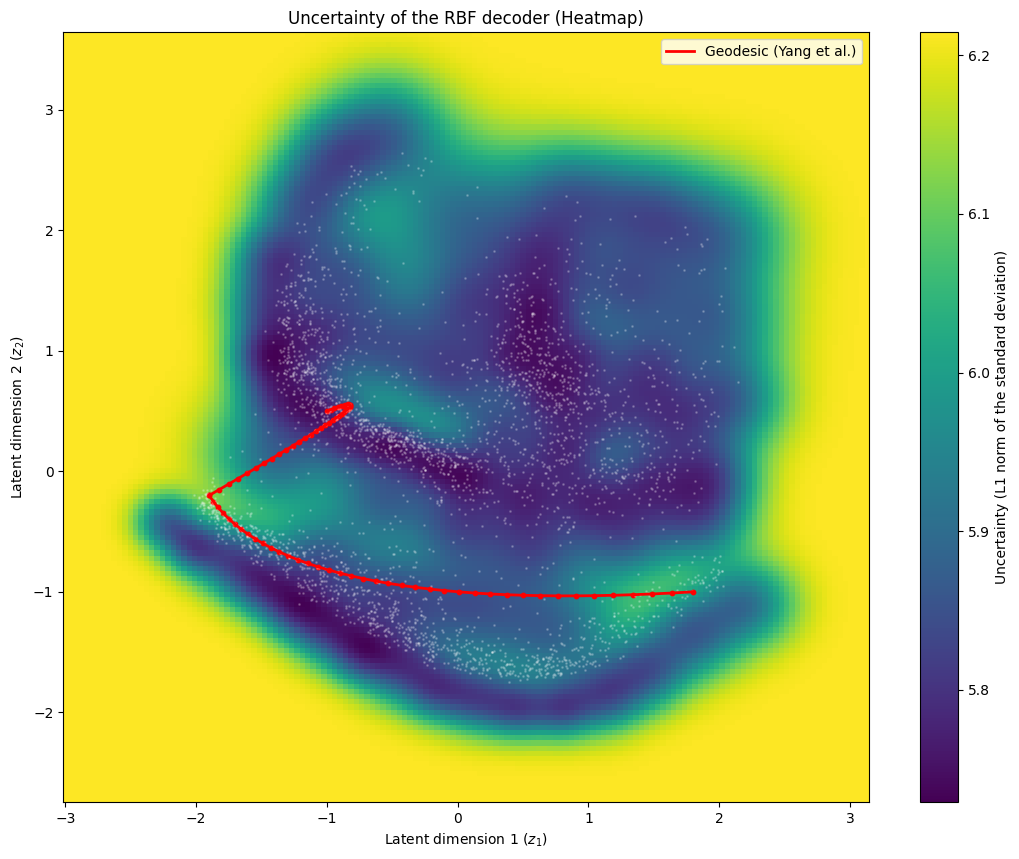

In [194]:
class QuadraticGeodesicOptimizer(nn.Module):
    """
    Implémentation exacte de la Section IV-A de Yang et al. (Eq. 19).
    La courbe est forcée d'être une parabole c(t) = at^2 + bt + c.
    """
    def __init__(self, z_a, z_b, n_points=30):
        super().__init__()
        self.n_points = n_points
        self.d = z_a.shape[0]

        # Points fixes
        self.register_buffer('z_a', z_a.to(DEVICE).float())
        self.register_buffer('z_b', z_b.to(DEVICE).float())

        # Paramètre 't' fixe pour l'évaluation (0, 1/n, ..., 1)
        self.register_buffer('t', torch.linspace(0, 1, n_points).unsqueeze(1).to(DEVICE))

        # LE SEUL paramètre entraînable est 'a' (la courbure)
        # Initialisé à 0 (ligne droite)
        self.a = nn.Parameter(torch.zeros(1, self.d).to(DEVICE))

    def get_full_path(self):
        # c = z_a
        # b = z_b - z_a - a
        b = self.z_b - self.z_a - self.a

        # c(t) = a*t^2 + b*t + c
        # t est (N, 1), a et b sont (1, d)
        path = (self.a * self.t**2) + (b * self.t) + self.z_a
        return path

    def forward(self, model):
        path = self.get_full_path()

        mu_path = model.decoder_mean(path)
        beta_path = torch.clamp(model.decoder_variance_rbf(path), min=1e-5)
        var_path = 1.0 / beta_path

        delta_mu = mu_path[1:] - mu_path[:-1]
        dist_term = torch.sum(delta_mu**2, dim=1)

        total_var = torch.sum(var_path, dim=1)
        var_term = total_var[:-1] + total_var[1:]

        return torch.sum(dist_term + var_term)


def calculate_geodesic_yang(z_a, z_b, model, n_points=30, steps=200, lr=0.01):
    """
    Fonction principale pour calculer la géodésique.
    """
    # Initialiser l'optimiseur de chemin
    geo_opt = QuadraticGeodesicOptimizer(z_a, z_b, n_points).to(DEVICE)

    # Optimiseur (Adam est généralement bon ici)
    optimizer = optim.Adam(geo_opt.parameters(), lr=lr)

    # Boucle d'optimisation
    loss_history = []

    # Barre de progression
    pbar = tqdm(range(steps), desc="Optimisation Géodésique (Yang)")

    for i in pbar:
        optimizer.zero_grad()

        # Calculer l'énergie (la perte)
        loss = geo_opt(model)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if i % 50 == 0:
            pbar.set_description(f"Loss: {loss.item():.2f}")

    return geo_opt.get_full_path().detach().cpu().numpy(), loss_history


def distance_riemann_yang(z_a, z_b, model):
    """
    Calcule la distance Riemannienne entre z_a et z_b.
    """
    geo_path, _ = calculate_geodesic_yang(z_a, z_b, model)
    return get_path_length(torch.tensor(geo_path, dtype=torch.float32).to(DEVICE), model)

za = torch.tensor([-1.9, -0.2])
zb = torch.tensor([-1.0, 0.5])
zc = torch.tensor([1.8, -1.0])

print("Calcul des géodésiques (Méthode Yang et al. 2018)...")
geodesic_path_ab, losses_ab = calculate_geodesic_yang(za, zb, model, n_points=40, steps=200, lr=0.05)
geodesic_path_ac, losses_ac = calculate_geodesic_yang(za, zc, model, n_points=40, steps=200, lr=0.05)
geodesic_path_bc, losses_bc = calculate_geodesic_yang(zb, zc, model, n_points=40, steps=200, lr=0.05)


# --- Affichage ---
plt.figure(figsize=(6, 6))

# Espace Latent

for digit in digits_to_use:
  latents = all_latents[all_labels == digit]
  plt.scatter(
    latents[:, 0],
    latents[:, 1],
    label='Digit {}'.format(digit),
    alpha=0.6,  # Transparence
    s=10        # Taille des points
)


# Chemin linéaire (Naïf)
linear_path_ab = np.vstack([
    np.linspace(za[0], zb[0], 40),
    np.linspace(za[1], zb[1], 40)
]).T
linear_path_ac = np.vstack([
    np.linspace(za[0], zc[0], 40),
    np.linspace(za[1], zc[1], 40)
]).T
linear_path_bc = np.vstack([
    np.linspace(zb[0], zc[0], 40),
    np.linspace(zb[1], zc[1], 40)
]).T
plt.plot(linear_path_ab[:, 0], linear_path_ab[:, 1], 'g--', label='Straight line (Euclidean)')
plt.plot(linear_path_ac[:, 0], linear_path_ac[:, 1], 'g--')

# Chemin Géodésique
plt.plot(geodesic_path_ab[:, 0], geodesic_path_ab[:, 1], 'r-', linewidth=2, label='Geodesic (Yang et al.)')
plt.scatter(geodesic_path_ab[:, 0], geodesic_path_ab[:, 1], c='red', s=10) # Points
plt.plot(geodesic_path_ac[:, 0], geodesic_path_ac[:, 1], 'r-', linewidth=2)
plt.scatter(geodesic_path_ac[:, 0], geodesic_path_ac[:, 1], c='red', s=10)

# Points de départ/fin
plt.scatter([za[0], zb[0], zc[0]], [za[1], zb[1], zc[1]], c='black', s=100, marker='X', label='Latent points')

plt.title("Comparison between Geodesics and Straight Lines")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()


lenght_geo_ab = get_path_length(torch.tensor(geodesic_path_ab, dtype=torch.float32).to(DEVICE), model)
print(f"Longueur de la géodésique AB : {lenght_geo_ab:.2f}")

length_linear_ab = get_path_length(torch.tensor(linear_path_ab, dtype=torch.float32).to(DEVICE), model)
print(f"Longueur de la ligne droite AB : {length_linear_ab:.2f}")

lenght_geo_ac = get_path_length(torch.tensor(geodesic_path_ac, dtype=torch.float32).to(DEVICE), model)
print(f"Longueur de la géodésique AC : {lenght_geo_ac:.2f}")

length_linear_ac = get_path_length(torch.tensor(linear_path_ac, dtype=torch.float32).to(DEVICE), model)
print(f"Longueur de la ligne droite AC : {length_linear_ac:.2f}")



plt.figure(figsize=(13, 10))

# Afficher la heatmap (la variance)
# 'origin=lower' est crucial pour aligner (0,0) en bas à gauche
# 'extent' mappe les pixels de l'image aux coordonnées de l'espace latent
im = plt.imshow(
    heatmap_image,
    cmap='viridis', # Vous pouvez essayer 'plasma', 'inferno', 'magma'
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    aspect='auto'
)

# Ajouter la barre de couleur
cbar = plt.colorbar(im)
cbar.set_label("Uncertainty (L1 norm of the standard deviation)")
plt.plot(geodesic_path_ab[:, 0], geodesic_path_ab[:, 1], 'r-', linewidth=2, label='Geodesic (Yang et al.)')
plt.scatter(geodesic_path_ab[:, 0], geodesic_path_ab[:, 1], c='red', s=10) # Points
plt.plot(geodesic_path_ac[:, 0], geodesic_path_ac[:, 1], 'r-', linewidth=2)
plt.scatter(geodesic_path_ac[:, 0], geodesic_path_ac[:, 1], c='red', s=10)

# Superposer les points de test
plt.scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,                     # Très petits points
    c='white',               # Couleur contrastante
    alpha=0.2,               # Transparence
    label=''
)

# Titres et labels
plt.title("Uncertainty of the RBF decoder (Heatmap)")
plt.xlabel("Latent dimension 1 ($z_1$)")
plt.ylabel("Latent dimension 2 ($z_2$)")
plt.legend(markerscale=10) 
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [195]:
def euclidean_path_length(path):
    # Si c'est un tensor, convertir en numpy
    if 'torch' in str(type(path)):
        path = path.detach().cpu().numpy()

    # Différences entre points consécutifs
    deltas = np.diff(path, axis=0)

    # Norme euclidienne pour chaque segment
    segment_lengths = np.linalg.norm(deltas, axis=1)

    # Somme des longueurs
    total_length = np.sum(segment_lengths)

    return total_length



length_geo_eucl = euclidean_path_length(torch.tensor(geodesic_path, dtype=torch.float32).to(DEVICE))
print(f"Longueur Euclidienne de la géodésique : {length_geo_eucl:.2f}")

length_linear_eucl = euclidean_path_length(torch.tensor(linear_path, dtype=torch.float32).to(DEVICE))
print(f"Longueur Euclidienne de la ligne droite : {length_linear_eucl:.2f}")



Longueur Euclidienne de la géodésique : 0.29
Longueur Euclidienne de la ligne droite : 1.14


Génération de la comparaison visuelle...


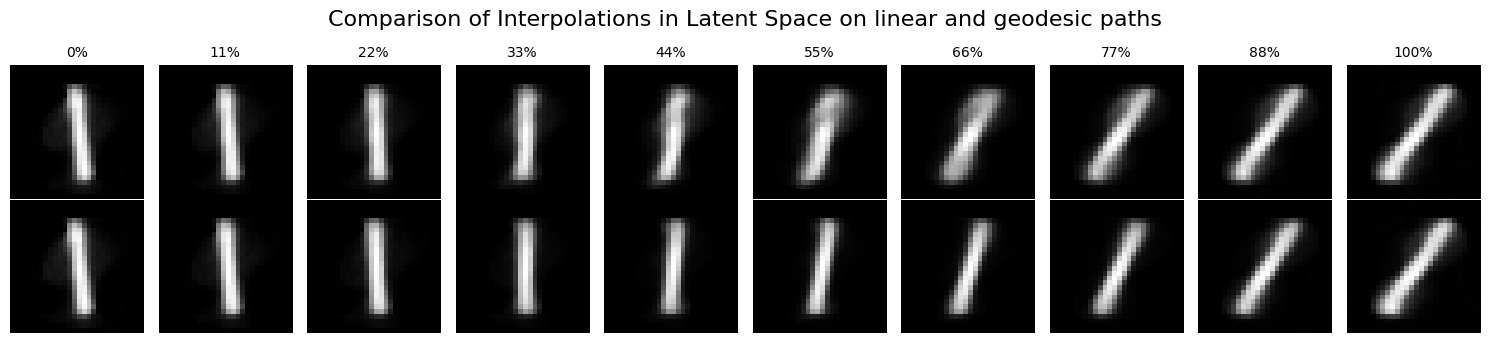

In [196]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- Fonction de Décodage et d'Affichage ---

def visualize_path_images(linear_path, geodesic_path, model, n_images=9):
    """
    Génère et affiche les images le long des chemins linéaire et géodésique.
    
    Args:
        linear_path (np.array): Chemin linéaire (N, d)
        geodesic_path (np.array): Chemin géodésique (N, d)
        model (VAE): Le modèle VAE entraîné
        n_images (int): Nombre d'images à afficher pour chaque chemin
    """
    model.eval()
    
    # 1. Sélectionner des indices équidistants le long des chemins
    # On suppose que les chemins ont plus de points que n_images
    indices_lin = np.linspace(0, len(linear_path) - 1, n_images, dtype=int)
    indices_geo = np.linspace(0, len(geodesic_path) - 1, n_images, dtype=int)
    
    
    # Extraire les points latents
    z_linear_subset = linear_path[indices_lin]
    z_geo_subset = geodesic_path[indices_geo]
    
    # Convertir en tenseurs
    z_linear_tensor = torch.tensor(z_linear_subset, dtype=torch.float32).to(DEVICE)
    z_geo_tensor = torch.tensor(z_geo_subset, dtype=torch.float32).to(DEVICE)
    
    # 2. Décoder les images (Passer dans le générateur)
    with torch.no_grad():
        # Décodeur moyenne mu(z)
        imgs_linear = model.decoder_mean(z_linear_tensor)
        imgs_geo = model.decoder_mean(z_geo_tensor)
        
        # Remodeler en (N, 28, 28)
        imgs_linear = imgs_linear.view(-1, 28, 28).cpu().numpy()
        imgs_geo = imgs_geo.view(-1, 28, 28).cpu().numpy()

    # 3. Créer la figure
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 1.5, 3.5))
    
    # Titres des lignes
    axes[0, 0].set_ylabel("Linéaire\n(Euclidien)", fontsize=14, rotation=0, labelpad=60, va='center')
    axes[1, 0].set_ylabel("Géodésique\n(Yang et al.)", fontsize=14, rotation=0, labelpad=60, va='center')

    for i in range(n_images):
        # Interpolation Linéaire
        axes[0, i].imshow(imgs_linear[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"{int(i/(n_images-1)*100)}%", fontsize=10)

        # Interpolation Géodésique
        axes[1, i].imshow(imgs_geo[i], cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Comparison of Interpolations in Latent Space on linear and geodesic paths", fontsize=16)
    plt.tight_layout()
    plt.show()

if 'linear_path_ac' in locals() and 'geodesic_path_ac' in locals():
    print("Génération de la comparaison visuelle...")
    visualize_path_images(linear_path_ac, geodesic_path_ac, model, n_images=10)
